# Load required libraries

In [1]:
import pandas as pd
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Download the datasets from private S3 bucket

In [2]:
!aws s3 cp 's3://ads508-team4-master/df_psych.csv' ./data/

download: s3://ads508-team4-master/df_psych.csv to data/df_psych.csv


In [3]:
import csv

df_psych = pd.read_csv(
    "./data/df_psych.csv",
    delimiter=",",
    quoting=csv.QUOTE_NONE,
)
df_psych = df_psych.iloc[:,1:]
df_psych.head(100)

,user_id,platform_x,level_1,level_2,level_3,confidence_score,country_code,asset_id,minutes_viewed,showtype,genre,running_minutes,source_language,season_id,series_id,studio_id,minutes_under_2
0,8.589935e+10,web-embed,Psychographics,Movies Lovers,Horror Movies Fans,0.07,ID,10377,1,Movies,Horror,87,Indonesian,NaN,NaN,350.0,True
1,8.589935e+10,web-embed,Psychographics,Movies Lovers,Indonesian Movies Fans,0.03,ID,10377,1,Movies,Horror,87,Indonesian,NaN,NaN,350.0,True
2,2.576980e+10,android,Psychographics,Movies Lovers,Romance Movies Fans,0.52,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
3,2.576980e+10,android,Psychographics,TV Lovers,Kids TV Fans,0.61,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
4,2.576980e+10,android,Psychographics,TV Lovers,Drama TV Fans,0.60,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7.700000e+01,android,Psychographics,Movies Lovers,Korean Movies Fans,0.54,ID,10377,12,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
96,7.700000e+01,android,Psychographics,Movies Lovers,English Movies Fans,0.46,ID,10377,12,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
97,7.700000e+01,android,Psychographics,TV Lovers,English TV Fans,0.40,ID,10377,12,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
98,6.871948e+10,android,Psychographics,TV Lovers,English TV Fans,0.29,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False


# Clean up missing values and outliers

## Missing values first

Recall that we have some missing values in the dataset

In [4]:
df_psych.isnull().sum()

user_id                  0
platform_x               0
level_1                  0
level_2                  0
level_3               4850
confidence_score         0
country_code             0
asset_id                 0
minutes_viewed           0
showtype                 0
genre                    5
running_minutes          0
source_language        701
season_id           146311
series_id           146311
studio_id              300
minutes_under_2          0
dtype: int64

It occurs to us that some level 2 traits do not have a subcategory and some records don't have genres so we remove those specific records.

In [5]:
df_psych = df_psych.dropna(subset=['level_3','genre'])
df_psych.isnull().sum()
print('\n')

We are going to see which studios are missing the source language.

In [6]:
df1 = df_psych[['studio_id','source_language']]
df2 = df1.loc[df1['source_language'].isna()]
print(df2['studio_id'].unique())

[229. 321.  10. 301.  79. 442. 373.  73. 127. 390.  69. 226. 170. 111.
 241. 447.]


In [7]:
df1[df1['studio_id'].isin([229., 321.,  10., 301.,  79., 442., 373.,  73., 127., 390.,  69.,
       226., 170., 111., 241., 447.])].groupby('studio_id')['source_language'].nunique()

studio_id
10.0     2
69.0     1
73.0     0
79.0     0
111.0    0
127.0    1
170.0    1
226.0    2
229.0    1
241.0    0
301.0    0
321.0    0
373.0    0
390.0    1
442.0    0
447.0    1
Name: source_language, dtype: int64

For the studios that are missing source language, there can be no language, one language or two languages. To avoid confusion, we will remove records with missing studio_id and source_language.

In [8]:
df_psych = df_psych.dropna(subset=['studio_id','source_language'])
df_psych.isnull().sum()

user_id                  0
platform_x               0
level_1                  0
level_2                  0
level_3                  0
confidence_score         0
country_code             0
asset_id                 0
minutes_viewed           0
showtype                 0
genre                    0
running_minutes          0
source_language          0
season_id           143369
series_id           143369
studio_id                0
minutes_under_2          0
dtype: int64

We can see that season_id and series_id have euqal amount of records and recall the showtype in the dataset has only 2 types.

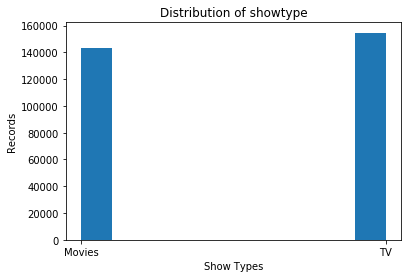

In [9]:
import matplotlib.pyplot as plt

plt.hist(df_psych['showtype'])
plt.xlabel("Show Types")
plt.ylabel("Records")
plt.title("Distribution of showtype")
plt.show()

In [10]:
df1 = df_psych[['showtype','season_id',"series_id"]]
df2 = df1.loc[(df1['season_id'].isna()) & (df1['series_id'].isna())]

In [11]:
df2.groupby('showtype')['season_id'].nunique()

showtype
Movies    1
Name: season_id, dtype: int64

In [12]:
df2.groupby('showtype')['series_id'].nunique()

showtype
Movies    1
Name: series_id, dtype: int64

This means that as long as we have valid season_id and series_id, the showtype must be TV shows while those values would be nulls for Movies.
Therefore, there is no need to keep season_id and series_id since they are directly correlated to showtype. So we remove the two columns.

In [13]:
df_psych = df_psych.drop(['season_id', 'series_id'], axis=1)
df_psych.isnull().sum()

user_id             0
platform_x          0
level_1             0
level_2             0
level_3             0
confidence_score    0
country_code        0
asset_id            0
minutes_viewed      0
showtype            0
genre               0
running_minutes     0
source_language     0
studio_id           0
minutes_under_2     0
dtype: int64

## Now consider outliers..